<a href="https://colab.research.google.com/github/cynthianekesa/Misala-App/blob/main/Misala_App_Medicinal_Plant_Identification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THE PROJECT**
*Explore the world of african medicinal plants through this notebook, where I tackle the challenge of classifying 27 different varieties. Leveraging state-of-the-art techniques in deep learning and image classification, the notebook delves into the nuances of plant parts morphology and texture to accurately identify each medicinal plant.*

# **USE CASES**

* Herbal Medicine Identification: Helping people identify medicinal plants for traditional remedies and herbal medicine preparation.

* Botanical Research: Assisting botanists and researchers in studying plant species diversity and distribution for conservation efforts.

* Pharmacological Studies: Supporting pharmacologists in understanding the therapeutic properties of different plants for drug discovery and development.

* Medical Education: Providing educational resources for students and healthcare professionals to learn about medicinal plants and their uses.

* Consumer Safety: Ensuring consumers can accurately identify and use medicinal plants without the risk of misidentification or harmful effects.

# **THE DATASET**

1.   **Data Aggregation**

[Dataset 1](https://universe.roboflow.com/medicinal-plants-snwoh/medleaf/dataset/10)

[Dataset 2](https://universe.roboflow.com/project-z499k/plant_detection_medicinal/dataset/1)


2.  **Data Transformation**

*   Initial dataset was in jpg files with different lables and repeated unbalanced classes
*   Applied data organization, category standardization, file management, quality control, and dataset enhancement
*   Dataset observation and outlier analysis
*   Hypothesis testing
*   Category distribution analysis, category comparison test and file size analysis
*  Density analysis
*  Dataset splitting with bias mitigation
*  Feature importance analysis and data handling

1.   **Aggregated dataset**

[Aggregated Dataset](https://universe.roboflow.com/cynthianekesa/misala-app/dataset/2)


# **APPROACH 1**

In [1]:
# Import modules

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import layers, models
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define data path

import os
import zipfile

zip_path = '/content/drive/MyDrive/Misala App.v2i.folder.zip'
dataset_path = './unzipped'

# Create the directory if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Unzipped to:", dataset_path)

Unzipped to: ./unzipped


In [5]:
# Browse data content

os.listdir(dataset_path)


['train']

In [6]:
# Data Preprocessing

def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

In [7]:
# Split dataset

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    './unzipped/train',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the data will be used for testing
    subset="training",     # Specify "training" to get the training subset
    seed=42,
    label_mode='int'
)
num_examples = data.cardinality().numpy()
num_classes = len(data.class_names)

# Split the data into training and testing
testing_data = tf.keras.utils.image_dataset_from_directory(
    './unzipped/train',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # No validation split for testing
    seed=42,
    label_mode='int',
    subset="validation"    # Specify "validation" to get the testing subset
)

Found 5586 files belonging to 27 classes.
Using 4469 files for training.
Found 5586 files belonging to 27 classes.
Using 1117 files for validation.


In [8]:
for images, labels in data.take(1):  # Take one batch from the dataset
    print(labels)
    #print(images)

tf.Tensor(
[ 3 12  5 16 17  4 16  0 26  2 24 17  7  3 26  1 22  9 10  4  3 13  3  5
  5  3  0 26  5 21 25  1], shape=(32,), dtype=int32)


In [9]:
# Constants
IMAGE_RES = 224  # InceptionV3 input shape
BATCH_SIZE = 32

In [10]:
# Image formatting and model training

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label
train_data = data
# Define the validation split ratio
validation_split = 0.2
num_validation_samples = int(num_examples * validation_split)
validation_data = data.take(num_validation_samples)

train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_batches, validation_data=validation_batches, epochs=10)

# Evaluate the model on the testing dataset
testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(testing_batches)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - accuracy: 0.4348 - loss: 2.1406 - val_accuracy: 0.8248 - val_loss: 0.6982
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8510 - loss: 0.6206 - val_accuracy: 0.9085 - val_loss: 0.4169
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9184 - loss: 0.3839 - val_accuracy: 0.9420 - val_loss: 0.2982
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9501 - loss: 0.2728 - val_accuracy: 0.9531 - val_loss: 0.2305
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9622 - loss: 0.2077 - val_accuracy: 0.9665 - val_loss: 0.1850
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9710 - loss: 0.1645 - val_accuracy: 0.9754 - val_loss: 0.1512
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9809 - loss: 0.1335 - val_accuracy: 0.9788 - val_loss: 0.1254
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34m

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 27)             │        34,587 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,361,747 (9.01 MB)

 Trainable params: 34,587 (135.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 69,176 (270.22 KB)

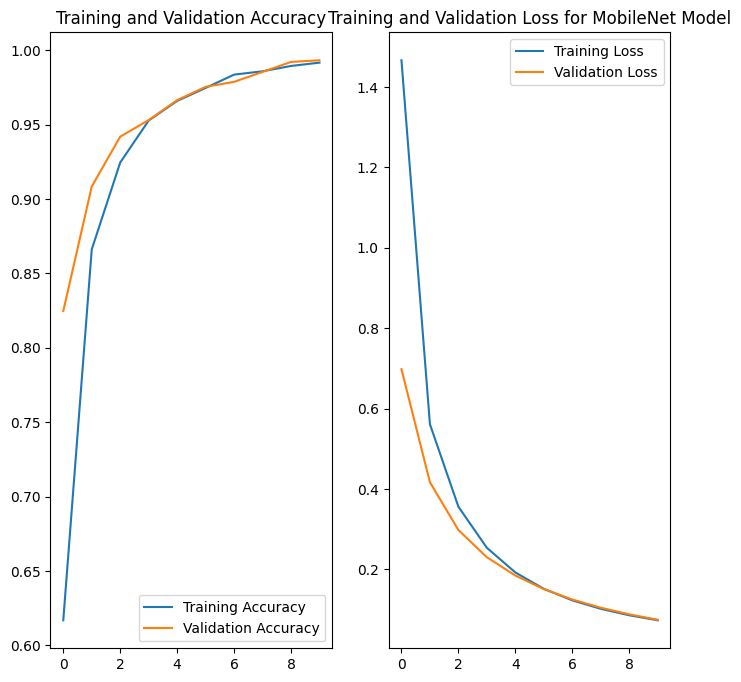

In [12]:
# Define the number of epochs
Epoch = 10

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


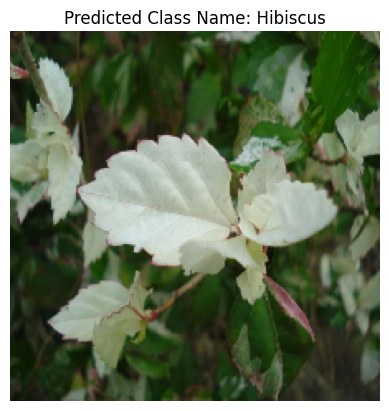

In [13]:
input_image_path = '/content/unzipped/train/Hibiscus/11468220605_2da1404d8d_b_jpg.rf.8556cba8636d5dd8f76cb70430981763.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

In [14]:
model.save('model1.h5')  # Saves as a single .h5 file

In [18]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open('modelh51.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpdf_4n_hg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 27), dtype=tf.float32, name=None)
Captures:
  134718942870416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980501136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980501712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718942870608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980500752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980501520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980503632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980504016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980503824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980500944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134720980505

In [16]:
model.save('model1.keras')

In [20]:
import tensorflow as tf

model = tf.keras.models.load_model('model1.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('modelkeras1.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmp7vpehq1t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 27), dtype=tf.float32, name=None)
Captures:
  134718952504784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952503440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952503056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952503248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952494032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952504976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952501136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952500752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952500944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952504016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134718952499

# **APPROACH 2**

In [21]:
import tensorflow as tf

In [22]:
# Covert images into dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './unzipped/train',
    shuffle=True,
    batch_size=32,
    image_size=(299, 299),
)

labels = dataset.class_names
labels

Found 5586 files belonging to 27 classes.


['Aloe vera',
 'Amaranthus-Viridis',
 'Basale',
 'Betel',
 'Carissa-Karanda',
 'Curry plant',
 'Ficus-Auriculata',
 'Ginger',
 'Guava leaf',
 'Hibiscus',
 'Holy Basil',
 'Jackfruit',
 'Jamaica-Cherry',
 'Jasmine',
 'Lemon',
 'Mango',
 'Mint',
 'Moringa',
 'Mustard',
 'Neem',
 'Oleander',
 'Pappaya',
 'Peepal',
 'Rasna',
 'Sandalwood plant',
 'Turmeric plant',
 'Unlabeled']

In [23]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 299, 299, 3)
[26 26 25  9 26 14 16 25 14 10 18  6 26 18 16 21 18 22 20  0 13 21  7 26
 10 17  2 10 13 23 22 13]


In [24]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(140, 35)

In [25]:
# Train, Test, Validate

def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [26]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(140, 35, 0)

In [27]:
# Resize and Normalize

# Xception models takes the image input as 299x299 pixels so converting into the trainable format is necessary The Images are to be normalized before to train accurately and efficiently

import tensorflow as tf

# Import preprocessing layers directly from tf.keras.layers.preprocessing
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    # Use Resizing and Rescaling directly from the updated location
    Resizing(299, 299),
    Rescaling(1./255)
])

In [28]:
# Download the Xception model predefined weights from tensorflow into working environment
# train using Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=25
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,127,235 (80.59 MB)

 Trainable params: 265,755 (1.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/25


In [ ]:
model.evaluate(test_ds)

In [ ]:
[0.023198062554001808, 1.0]

In [ ]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/content/unzipped/train/Jackfruit/AH-S-003_jpg.rf.f6108af8c61f1d8b31967d32d374a016.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch


predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/content/unzipped/train/Moringa/10008_jpg.rf.5480ca60242055125abec67c8f93a4e4.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/content/unzipped/train/Oleander/36220_04_jpg.rf.20360dce1f7370195a2c302b08dfd9a5.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('model2.h5')

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model.save('model2.keras')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('model1.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# **APPROACH 3**